In [2]:
%pylab
%matplotlib inline
import pandas as pd
import numpy as np
from numba import jit
from scipy import stats
from scipy.stats import spearmanr, entropy
%config InlineBackend.figure_format = 'svg'
import glob

from IPython.core.debugger import Pdb

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


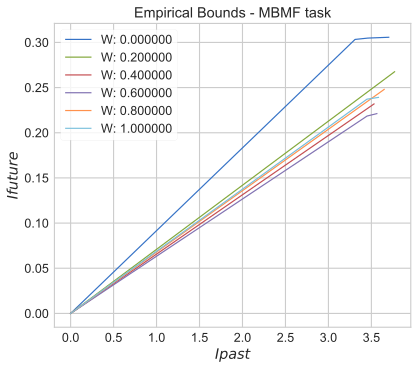

In [3]:
hull_names = sort(glob.glob('./MBMF_bounds/*.npy'))

hulls = {}
for i,key in enumerate(np.arange(0.0,1.1,.1)):
    if i%2 == 0:
        hulls[key] = np.load(hull_names[i])
        hull = hulls[key]
        plot(hull[:-1,0],hull[:-1,1],'-',label='W: %f'%key)
xlabel('$Ipast$')
ylabel('$Ifuture$')
title('Empirical Bounds - MBMF task')
legend()

In [4]:
#Load data
read_data = np.load('data/DAW_DATA_FOR_CLUSTER.npy').item()

In [5]:
print(read_data)

{0.0: {'R2': array([1, 2, 1, ..., 2, 2, 2], dtype=uint8), 'Rw': array([1, 1, 0, ..., 1, 1, 0], dtype=uint8), 'R1': array([2, 1, 2, ..., 2, 1, 1], dtype=uint8), 'S2': array([1, 2, 1, ..., 1, 1, 1], dtype=uint8), 'best_R1': array([0, 0, 0, ..., 1, 1, 1])}, 0.1: {'R2': array([1, 2, 1, ..., 1, 1, 1], dtype=uint8), 'Rw': array([1, 0, 0, ..., 0, 0, 1], dtype=uint8), 'R1': array([1, 2, 1, ..., 1, 2, 2], dtype=uint8), 'S2': array([1, 2, 1, ..., 2, 1, 1], dtype=uint8), 'best_R1': array([0, 0, 0, ..., 1, 1, 1])}, 0.8: {'R2': array([2, 2, 1, ..., 2, 2, 1], dtype=uint8), 'Rw': array([0, 1, 0, ..., 0, 0, 0], dtype=uint8), 'R1': array([2, 1, 1, ..., 2, 2, 1], dtype=uint8), 'S2': array([1, 2, 2, ..., 1, 1, 2], dtype=uint8), 'best_R1': array([0, 0, 0, ..., 1, 1, 1])}, 0.30000000000000004: {'R2': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8), 'Rw': array([1, 1, 0, ..., 1, 0, 0], dtype=uint8), 'R1': array([1, 1, 1, ..., 1, 1, 2], dtype=uint8), 'S2': array([2, 2, 2, ..., 1, 2, 2], dtype=uint8), 'best_R1': 

In [9]:
def trial_label(x):
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)

def make_features(trials_data):
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data

In [10]:
def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) 
                      for xi in np.unique(x)])/len(x)
    return px

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return joint_x_y

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi


In [18]:
predInfo = {}
for w in read_data:
    print('Computing pred info %f...'%w)
    subject = read_data[w]
    keys = ['S2', 'R1', 'R2', 'Rw', 'best_R1']
    trials = np.vstack([subject[key] for key in keys])
    features = make_features(trials)
    
    resp = subject['R1']
    
    #Ipast and Ifuture
    predInfo[w] = [mutual_inf(features[:-2],resp[2:]),mutual_inf(features[1:],resp[:-1])]
    

Computing pred info 0.000000...
Computing pred info 0.100000...


/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Computing pred info 0.800000...
Computing pred info 0.300000...
Computing pred info 1.000000...
Computing pred info 0.900000...
Computing pred info 0.200000...
Computing pred info 0.600000...
Computing pred info 0.700000...
Computing pred info 0.400000...
Computing pred info 0.500000...


In [19]:
print(predInfo)

{0.0: [0.08776099380647431, 0.06875495850380652], 0.1: [0.07209128806794611, 0.05700164439998327], 0.8: [0.03134720076890875, 0.01579229561583523], 0.30000000000000004: [0.04151777742270098, 0.02975499147048883], 1.0: [0.02642670000085574, 0.010299905736471751], 0.9: [0.025421779460777828, 0.010165225894991171], 0.2: [0.06278710721498687, 0.045663582150512326], 0.6000000000000001: [0.02747464564825285, 0.012425629076625734], 0.7000000000000001: [0.02719987154565228, 0.011912858764141335], 0.4: [0.04140516688009787, 0.024059850704018514], 0.5: [0.034459053028164925, 0.015147956998023722]}


ValueError: num must be 1 <= num <= 10, not 11

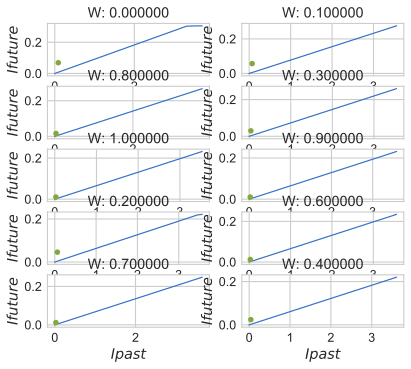

In [26]:
figure()
for i,key in enumerate(read_data):
    subplot(5,2,i+1)
    hulls[key] = np.load(hull_names[i])
    hull = hulls[key]
    plot(hull[:-1,0],hull[:-1,1],'-')
    plot(predInfo[key][0],predInfo[key][1],'o')
    xlabel('$Ipast$')
    ylabel('$Ifuture$')
    title('W: %f'%key)

AxisError: axis -1 is out of bounds for array of dimension 0